# Testing different pipeline elements
This notebook contains different miscellaneous tests to ensure that the behavior of our pipeline elements is correct.

In [2]:
import json
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import time
import matplotlib.pyplot as plt
from matplotlib import cm as CM

import sys
sys.path.append('/Users/emiliolr/Desktop/counting-cranes')

from bird_dataset import *
from utils import *
from density_estimation.generate_density import *

In [3]:
config = json.load(open('/Users/emiliolr/Desktop/counting-cranes/config.json', 'r'))
DATA_FP = config['data_filepath_local']
SEED = config['random_seed']

## Testing utility functions (`utils.py`)

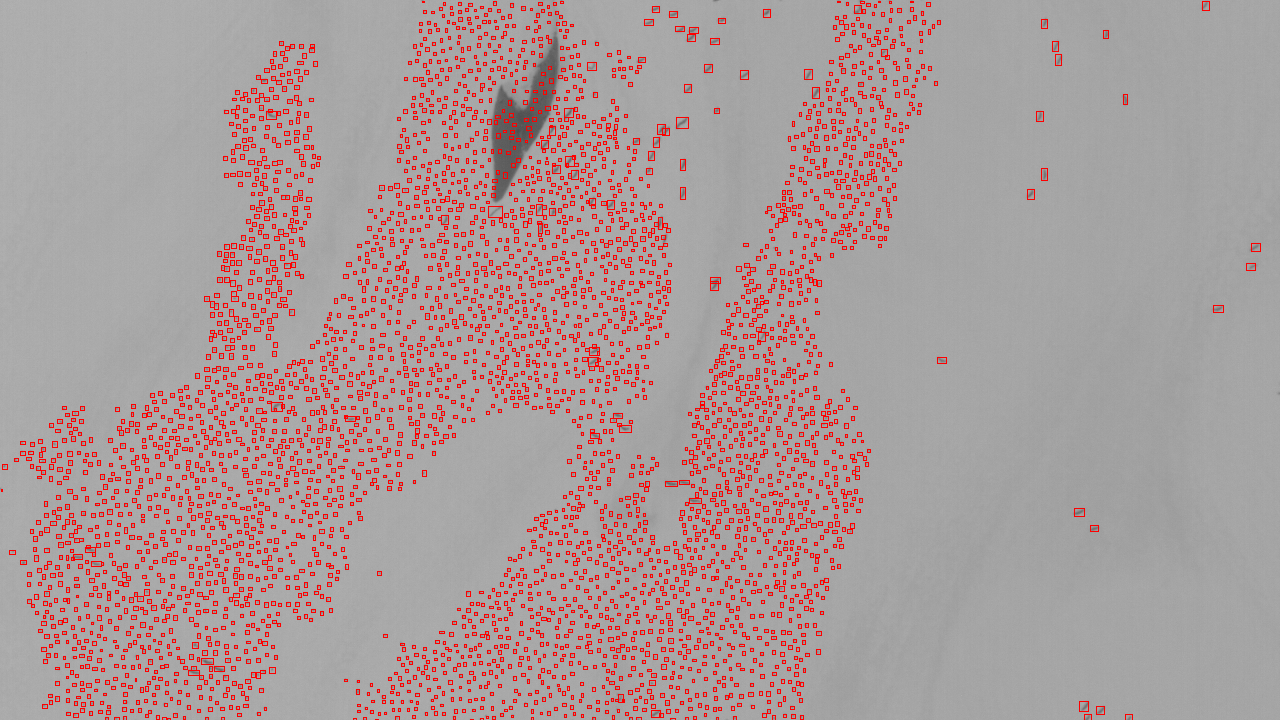

In [5]:
#Checking that bbox extraction and visualization work correctly
img_fp = os.path.join(DATA_FP, 'images/FLIR2_20210321_201851_358_2510.TIF')
annot_fp = os.path.join(DATA_FP, 'annotations/FLIR2_20210321_201851_358_2510.xml')

visualize_bboxes(img_fp, annot_fp)

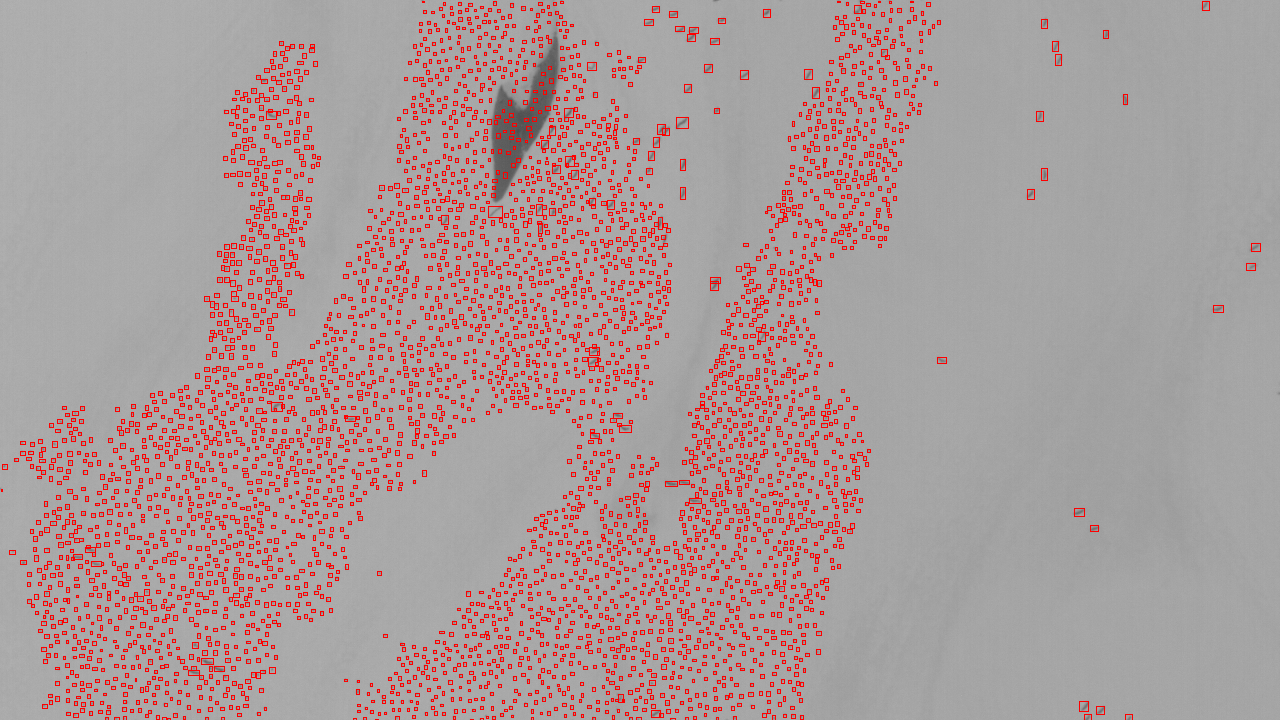

In [4]:
#Checking secondary behavior for visualize_bboxes
pil_img = Image.open(img_fp)
bboxes = get_bboxes(annot_fp)

visualize_bboxes(None, None, pil_img, bboxes)

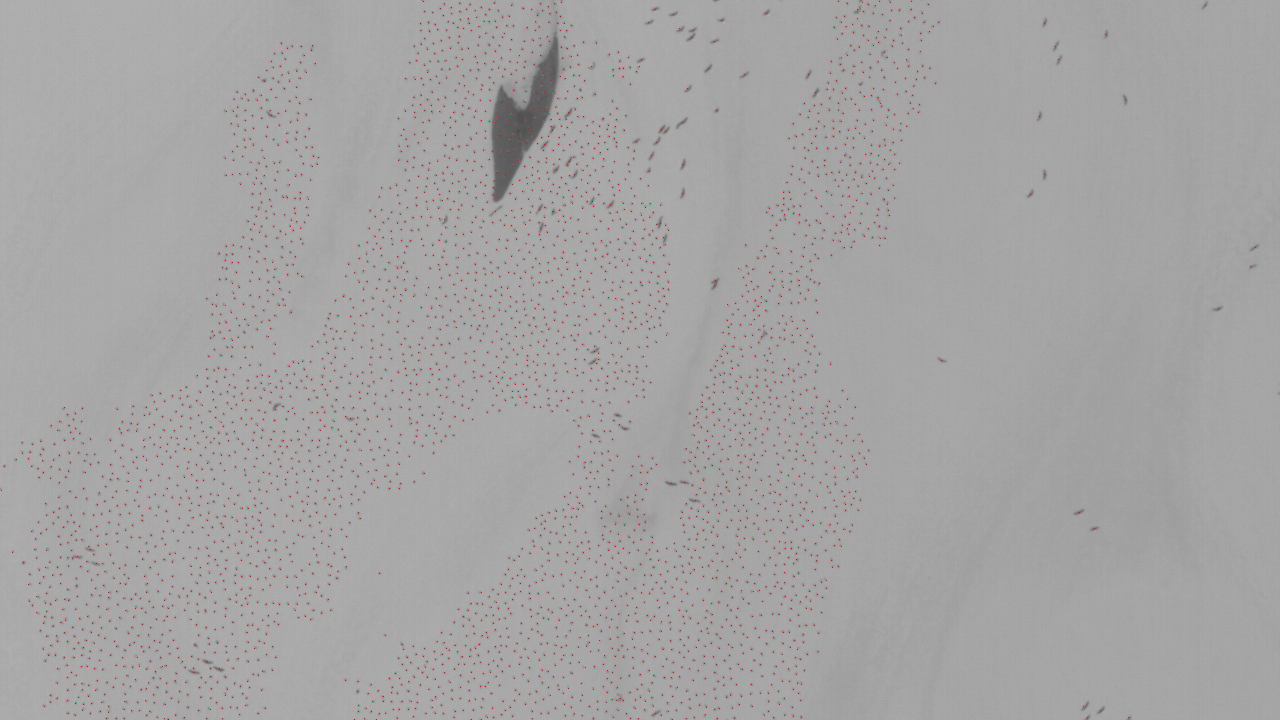

In [4]:
#Checking that point annotation translation and visualization work correctly
visualize_points(img_fp, annot_fp)

In [6]:
#Testing regression annotation type
print(f'{img_fp.split("/")[-1]} contains {get_regression(annot_fp)} birds in total')

FLIR2_20210321_201851_358_2510.TIF contains 4292 birds in total


## Testing the `BirdDataset` object (bboxes)


In [5]:
#Putting the dataset in a DataLoader
bird_dataset = BirdDataset(root_dir = DATA_FP, transforms = get_transforms(train = False), tiling_method = 'random')
dataloader = DataLoader(bird_dataset, batch_size = 1, shuffle = True, collate_fn = collate_tiles_object_detection)

#Pulling a batch out of the iterator
images, targets, _, _ = next(iter(dataloader))
print(f'Batch size of {len(images)} with each tensor of shape {images[0].shape}')
print(f'We have a {type(targets)} of {type(targets[0])}')

Batch size of 18 with each tensor of shape torch.Size([3, 224, 224])
We have a <class 'list'> of <class 'dict'>


In [6]:
#Checking data types of dictionary elements
t = targets[0]
print(f'Bounding boxes are {t["boxes"].dtype}')
print(f'Labels are {t["labels"].dtype}')

Bounding boxes are torch.float32
Labels are torch.int64


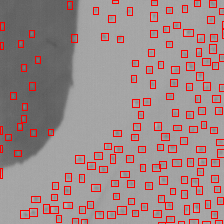

In [8]:
#Inspecting images
index = 0
img = np.moveaxis(images[index].numpy(), 0, -1) * 255
bb = targets[index]['boxes'].tolist()

pil_img = Image.fromarray(img.astype(np.uint8))
draw = ImageDraw.Draw(pil_img)
for b in bb:
    draw.rectangle(b, outline = 'red', width = 1)
pil_img

In [9]:
#Checking the target dictionaries
print(f'{len(targets[index]["boxes"])} birds in tile {index}')

154 birds in tile 0


In [11]:
#Number of negative examples in the batch?
neg_ex_ct = 0
for t in targets:
    if len(t['boxes']) == 0:
        neg_ex_ct += 1
print(f'We have {neg_ex_ct} negative examples in this batch')

We have 0 negative examples in this batch


In [24]:
#Can we make it all the way through the DataLoader, i.e., is this process working for all parent images?
#  - we should see it get through 34 images...
for num, data in enumerate(dataloader):
    print(f'On image {num}')

On image 0
On image 1
On image 2
On image 3
On image 4
On image 5
On image 6
On image 7
On image 8
On image 9
On image 10
On image 11
On image 12
On image 13
On image 14
On image 15
On image 16
On image 17
On image 18
On image 19
On image 20
On image 21
On image 22
On image 23
On image 24
On image 25
On image 26
On image 27
On image 28
On image 29
On image 30
On image 31
On image 32
On image 33


## Testing for cropping w/`albumentations`
Getting everything into functions and ensuring that behavior is correct. The notebook format is good for visual confirmation!

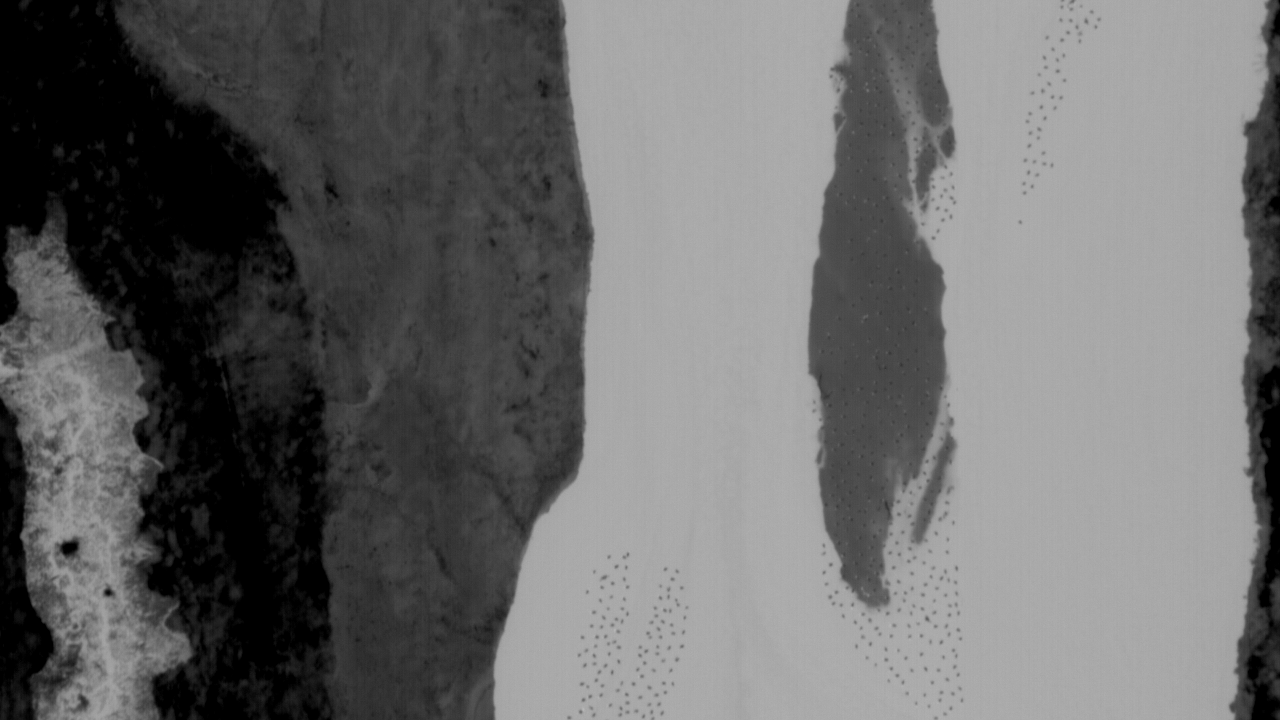

In [239]:
#Taken from way above...
img_fp = os.path.join(DATA_FP, 'images/FLIR2_20210321_225958_453_7161.TIF')
annot_fp = os.path.join(DATA_FP, 'annotations/FLIR2_20210321_225958_453_7161.xml')

image = Image.open(img_fp).convert('RGB')
bboxes = get_bboxes(annot_fp)
labels = np.ones((len(bboxes), ))
image

In [267]:
#Trying out tiling function
tiles, targets = tiling_w_o_overlap(image, bboxes, labels)

In [277]:
#Quickly checking final tile preparation
batch_of_tiles = []
for i, content in enumerate(zip(tiles, targets)):
    img, target = content
    target_dict = {}
    target_dict['boxes'] = torch.as_tensor(target['boxes'], dtype = torch.float32)
    target_dict['labels'] = torch.as_tensor(target['labels'], dtype = torch.int64)
    batch_of_tiles.append((img, target_dict))

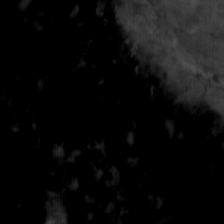

In [276]:
#Inspecting images
index = 0
img = np.moveaxis(tiles[index].numpy(), 0, -1) * 255
bb = targets[index]['boxes']

pil_img = Image.fromarray(img.astype(np.uint8))
draw = ImageDraw.Draw(pil_img)
for b in bb:
    draw.rectangle(b, outline = 'red', width = 1)
pil_img

## Testing ground truth density generation
Visual confirmation and time tests.

In [5]:
#Pulling inthe image and annotations
single_annot_fp = '/Users/emiliolr/Desktop/Conservation Research/final_dataset/annotations/20180321_223204_097_2806.xml'
single_img_fp = '/Users/emiliolr/Desktop/Conservation Research/final_dataset/images/20180321_223204_097_2806.tif'

bboxes = get_bboxes(single_annot_fp)
img = np.array(Image.open(single_img_fp))

In [7]:
#Density w/adaptive filter
start = time.time()
adaptive_density = density_from_bboxes(bboxes, img, filter_type = 'adaptive')
end = time.time()
print(f'It took {end - start} seconds to produce the adaptive density')

It took 97.99705505371094 seconds to produce the adaptive density


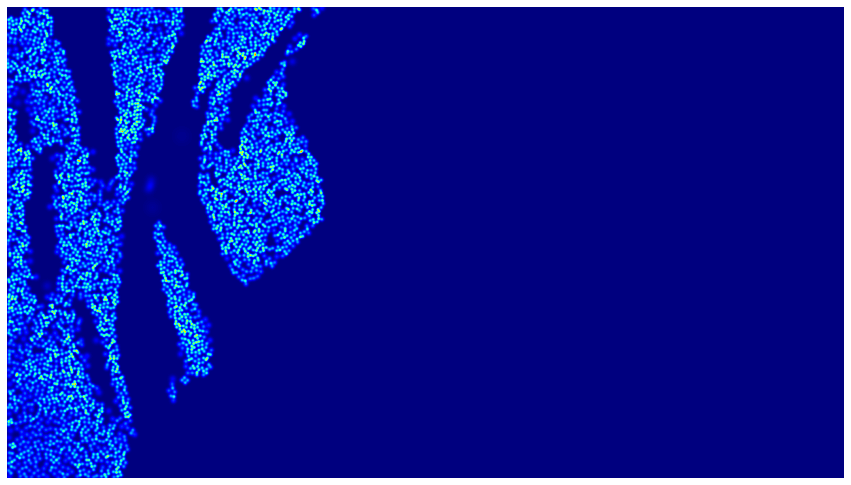

In [8]:
#Checking out the density
plt.figure(figsize = (15, 10))
plt.axis('off')
plt.imshow(adaptive_density, cmap = CM.jet);

In [10]:
#Does the density sum to the image count like it's supposed to?
print(f'Count according to adaptive density is {round(np.sum(adaptive_density))} and actual is {len(bboxes)}')

Count according to adaptive density is 3781 and actual is 3795


In [13]:
#Density w/fixed filter
start = time.time()
fixed_density = density_from_bboxes(bboxes, img, filter_type = 'fixed', sigma = 1.5)
end = time.time()
print(f'It took {end - start} seconds to produce the fixed density')

It took 0.10161900520324707 seconds to produce the fixed density


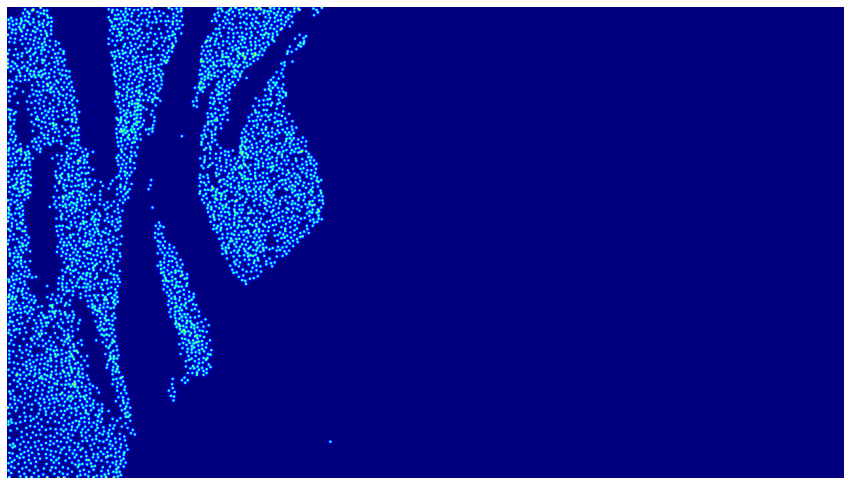

In [14]:
#Checking out the density
plt.figure(figsize = (15, 10))
plt.axis('off')
plt.imshow(fixed_density, cmap = CM.jet);

In [15]:
#Does the density sum to the image count like it's supposed to?
print(f'Count according to fixed density is {round(np.sum(fixed_density))} and actual is {len(bboxes)}')

Count according to fixed density is 3795 and actual is 3795


## Testing the `BirdDataset` object (density)

In [21]:
#Putting the dataset in a DataLoader
bird_dataset = BirdDataset(root_dir = DATA_FP, transforms = get_transforms(train = False), tiling_method = 'random', annotation_mode = 'points')
dataloader = DataLoader(bird_dataset, batch_size = 1, shuffle = True, collate_fn = collate_tiles_density)

#Pulling a batch out of the iterator
images, densities = next(iter(dataloader))
print(f'Batch size of {len(images)} with each image tensor of shape {images[0].shape}')
print(f'We have a {type(densities)} of {type(densities[0])} for our densities')

0
0
0
0
0
0
87
77
71
264
193
252
29
234
297
160
81
71
Batch size of 18 with each image tensor of shape torch.Size([3, 224, 224])
We have a <class 'list'> of <class 'torch.Tensor'> for our densities


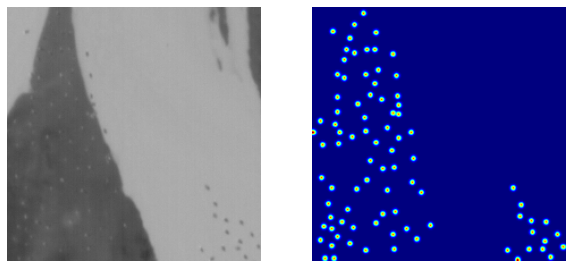

In [23]:
#Inspecting densities and images
index = 6
img = (np.moveaxis(images[index].numpy(), 0, -1) * 255).astype(np.uint8)
den = densities[index]

f, axarr = plt.subplots(1, 2, figsize = (10, 10))
axarr[0].imshow(img)
axarr[1].imshow(den, cmap = CM.jet)
for a in axarr:
    a.axis('off')

In [24]:
#Checking counts
print(f'In image {index} there are {np.sum(den.numpy())} birds')

In image 6 there are 87.0 birds
